# Time series analysis with Pandas 

In this session we learn how to use Pandas for time series analysis. The exercise is to read in meteorological data from a table and to calculate anomalies. 

The meteorological data used for the following example are available here
http://icdc.zmaw.de/daten/atmosphere/dwd-station.html

Suggested textbooks for Pandas 

 * http://dx.doi.org/10.1007/978-1-4842-0958-5 Python Data Analytics

 * https://github.com/wesm/pydata-book Python for data analysis


## Modules

First we import some modules

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Read data from table to Pandas DataFrame object

In [2]:
fn='dwdstation_hamburg_fuhlsbuettel_kl_10147.csv'
DF=pd.read_csv(fn,encoding = "ISO-8859-1",usecols=[6,7,8,15],parse_dates=[[0,1,2]])
DF.head()

,Jahr_ Monat_ Tag,Tagesmittel der Temperatur der Luft in 2m Hoehe (grad C)
0,1891-01-01,-10.7
1,1891-01-02,-7.6
2,1891-01-03,-10.3
3,1891-01-04,-1.3
4,1891-01-05,-4.1


## Rename columns

In [3]:
DF.columns=['Date','T'] # Make column names shorter
DF.head()

,Date,T
0,1891-01-01,-10.7
1,1891-01-02,-7.6
2,1891-01-03,-10.3
3,1891-01-04,-1.3
4,1891-01-05,-4.1


## Determine and change data type

In [4]:
DF.dtypes

Date    datetime64[ns]
T               object
dtype: object

### <font color=red>Be careful, T is not yet a numeric type, it was read in as a string object. This would prevent numeric calculation and plotting!</font>

In [5]:
DF['T']=DF['T'].astype(float)

In [6]:
DF.dtypes

Date    datetime64[ns]
T              float64
dtype: object

## Create Pandas Datetime and Series objects

In [7]:
dates=pd.to_datetime(DF['Date'].values)
T=pd.Series(DF['T'].values,index=dates) # Create a time series with date index

Text(0.5,1,'DWD Station Hamburg Fuhlsbüttel')

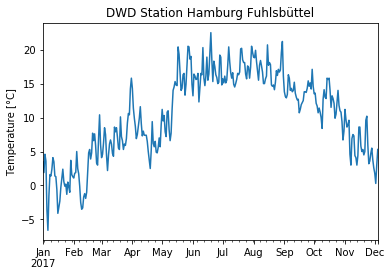

In [8]:
T['2017-01-01':].plot() # Slicing works with date index!
ylabel('Temperature [°C]')
title('DWD Station Hamburg Fuhlsbüttel')

## Generate periods for averaging

|Code | Offset | Description   |
|-----|--------|---------------|
|D    | Day    | Calendar daily|
|B    | BusinessDay| Business daily|
|H    |Hour    |Hourly |
|T or min| Minute | Minutely |
|S |Second |Secondly |
|L or ms| Milli |Millisecond |
|U |Micro | Microsecond |
|M |MonthEnd |Last calendar day of month|
|BM |BusinessMonthEnd | Last business day (weekday) of month|
|MS |MonthBegin | First calendar day of month|
|BMS|BusinessMonthBegin| First weekday of month|
|W-MON, W-TUE, ...| Week | Weekly on given day of week|
|A-JAN, A-FEB, ...|YearEnd| Annual dates anchored on last calendar day of given month|
|AS-JAN, AS-FEB, ...| YearBegin |Annual dates anchored on first day of given month|


In [9]:
month_index=dates.to_period(freq='M')
month_index

PeriodIndex(['1891-01', '1891-01', '1891-01', '1891-01', '1891-01', '1891-01',
             '1891-01', '1891-01', '1891-01', '1891-01',
             ...
             '2017-11', '2017-11', '2017-11', '2017-11', '2017-11', '2017-11',
             '2017-12', '2017-12', '2017-12', '2017-12'],
            dtype='period[M]', length=46359, freq='M')

## Add period to data frame

In [10]:
DF['month index']=month_index.month
DF['year-month']=month_index

In [11]:
DF.tail()

,Date,T,month index,year-month
46354,2017-11-30,2.6,11,2017-11
46355,2017-12-01,1.8,12,2017-12
46356,2017-12-02,0.3,12,2017-12
46357,2017-12-03,3.0,12,2017-12
46358,2017-12-04,5.3,12,2017-12


## Caculate seasonal cycle and monthly means 

In [12]:
seasonal=DF.groupby('month index').mean()

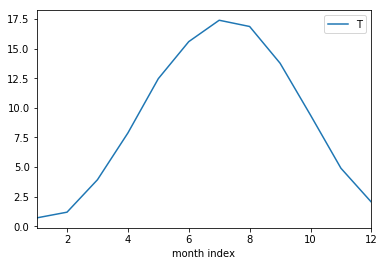

In [13]:
seasonal.plot()

In [14]:
monthly_means=DF.groupby('year-month')['T'].mean()

In [15]:
monthly_means.head()

year-month
1891-01    -3.664516
1891-02     0.682143
1891-03     2.129032
1891-04     5.720000
1891-05    12.074194
Freq: M, Name: T, dtype: float64

In [16]:
DF_monthly=pd.DataFrame({'Date':monthly_means.index,'T':monthly_means.values})

In [17]:
DF_monthly.head()

,Date,T
0,1891-01,-3.664516
1,1891-02,0.682143
2,1891-03,2.129032
3,1891-04,5.720000
4,1891-05,12.074194


## Calculate anomalies

Not sure if there is  better function?

In [18]:
years=int(len(DF_monthly)/12)
DF_monthly['seasonal']=reshape(repeat(seasonal.values,years),(12,years)).T.flatten() # Tricky
# We repeat the seasonal cycle year by year

# Calculate anomalies
DF_monthly['Anomaly']=DF_monthly['T']-DF_monthly['seasonal']
DF_monthly.head()

,Date,T,seasonal,Anomaly
0,1891-01,-3.664516,0.710897,-4.375413
1,1891-02,0.682143,1.195121,-0.512978
2,1891-03,2.129032,3.932309,-1.803277
3,1891-04,5.720000,7.877323,-2.157323
4,1891-05,12.074194,12.463043,-0.388849


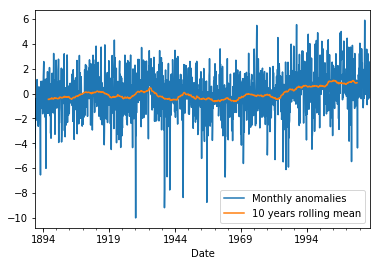

In [19]:
#Convert to Series
T_anom=pd.Series(DF_monthly['Anomaly'].values,index=DF_monthly['Date'])

# Plot
T_anom.plot(label='Monthly anomalies')
T_anom.rolling(12*10,center=True).mean().plot(label='10 years rolling mean')
legend()